In [1]:
import sys
sys.path.append("../..")

In [2]:
model_path = '../../trained_models/simclr/'
dataset = 'panoptic'

# Imports

In [3]:
import os
import torch
import re
import random
from torchvision.io import read_image

import matplotlib.pyplot as plt
import torchvision.transforms as T

## SimCLR method
[SimCLR](https://arxiv.org/pdf/2002.05709.pdf) I take the base encoder model (ResNet50) and replace its fully connected layer with a projection head.

In [4]:
from contrastive_training.simclr.model import get_simclr_net

# Clustering

I extract the representations from the trained model and run K means clustering algorithm (number of clusters=8) on these representation. I reduce the dimentionality of the representations with PCA and LDA algorithm and plot the clustering.
For the comparison I use the representations extracted from encoder model (before the projection head) and the representations extracted after the projection head.

## Setup

In [5]:
from dataloaders.datasets import cluster_datasets

In [6]:
def get_cluster_data(batch_size, dataset='panoptic'):
    transforms = T.Compose(
        [
            T.ToTensor(),
            T.Resize(size=(128, 128)),
        ]
    )

    cluster_dataset = cluster_datasets[dataset](transforms, dataset_dir='../../datasets')
    
    cluster_loader = torch.utils.data.DataLoader(cluster_dataset, batch_size)

    return cluster_dataset, cluster_loader

In [7]:
def extract_representations(path, cluster_loader, load=True):
    net = get_simclr_net()

    if load:
        net.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

    net.to('cpu')
    net.eval()

    proj_repr = []
    base_repr = []

    with torch.no_grad():
        for batch_idx, inputs in enumerate(cluster_loader):
            images = inputs['image']
            images.to('cpu')
            base, proj = net(images)
            proj_repr.append(proj)
            base_repr.append(base)

    return torch.cat(base_repr).numpy(), torch.cat(proj_repr).numpy()

In [8]:
from sklearn.cluster import KMeans


def kmeans_algorithm(features, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(features)

    return kmeans.labels_

In [9]:
#import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#import PCA
from sklearn.decomposition import PCA

def reduce_dim_LDA(features, labels, n_components=2):
    lda = LDA(n_components=n_components)
    lda.fit(features, labels)

    return lda.transform(features)

def reduce_dim_PCA(features, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(features)

    return pca.transform(features)

In [10]:
def plot_clusters(clusters, features, title):
    colors = {
        0: '#F8512E', 1: '#F8F82E',
        2: '#40F82E', 3: '#2EC1F8',
        4: '#6B2EF8', 5: '#D92EF8',
        6: '#731642', 7: '#092040'
    }

    cluster_colors = [colors[c] for c in clusters]

    plt.scatter(features[:, 0], features[:, 1], c=cluster_colors)
    plt.title(title)
    plt.show()

In [11]:
from sklearn.metrics import silhouette_score


def cluster(model_path, load=True, n_clusters=8, n_components=2, dataset='panoptic'):
    cluster_set, cluster_loader = get_cluster_data(30, dataset)

    base_features, proj_features = extract_representations(model_path, cluster_loader, load)

    labels_base = kmeans_algorithm(features=base_features, n_clusters=n_clusters)
    lda_base = reduce_dim_LDA(features=base_features, labels=labels_base, n_components=n_components)
    pca_base = reduce_dim_PCA(features=base_features, n_components=n_components)

    labels_proj = kmeans_algorithm(proj_features, n_clusters=n_clusters)
    lda_proj = reduce_dim_LDA(features=proj_features, labels=labels_proj, n_components=n_components)
    pca_proj = reduce_dim_PCA(features=proj_features, n_components=n_components)

    silhouette_base = silhouette_score(base_features, labels_base)
    silhouette_proj = silhouette_score(proj_features, labels_proj)

    print("Silhouette score for the encoder features: {}".format(silhouette_base))
    print("Silhouette score for the projection head features: {}".format(silhouette_proj))

    plot_clusters(labels_base, lda_base, "Encoder features LDA")
    plot_clusters(labels_proj, lda_proj, "Projection head features LDA")

    plot_clusters(labels_base, pca_base, "Encoder features PCA")
    plot_clusters(labels_proj, pca_proj, "Projection head features PCA")

    return cluster_set, base_features, proj_features, labels_base, labels_proj, lda_base, lda_proj, pca_base, pca_proj

In [12]:
#get the latest model
epoch = 0
for file in os.listdir(model_path):
    if 'epoch' in file:
        e = int(re.findall(r'\d+', file)[0])
        if e > epoch:
            epoch = e

path = model_path + 'epoch_{:d}.pth'.format(epoch)

#path="trained_models/ver1.pt"

## Before training

c:\Users\david\Documents\PROGETTI\SIV\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Silhouette score for the encoder features: 0.09855788201093674
Silhouette score for the projection head features: 0.08588112145662308


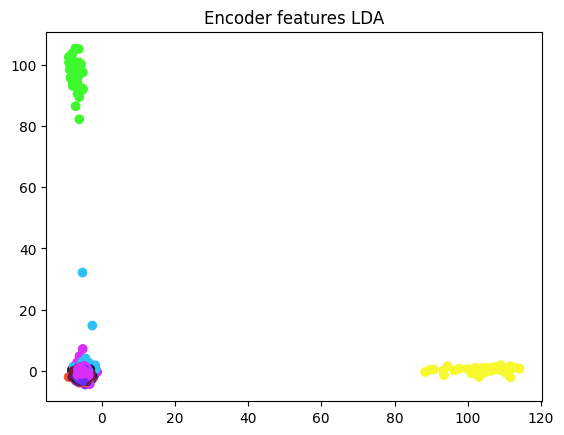

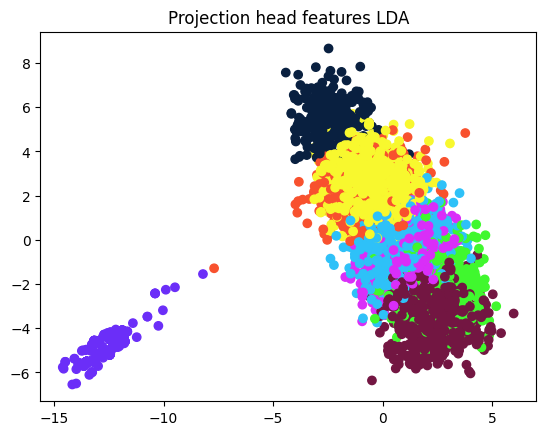

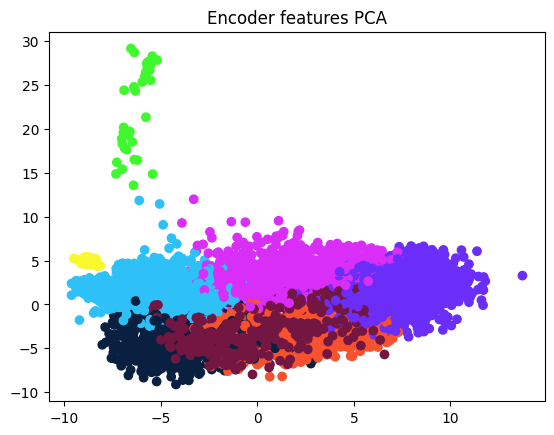

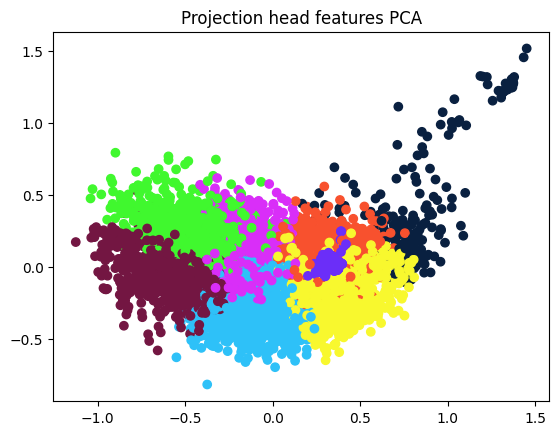

In [13]:
_, _, _, _, _, _, _, _, _ = cluster(path, load=True, n_clusters=8, n_components=2, dataset=dataset)

## Trained model
visualization based on the model preprained with 0.0001 learning rate for base encoder

c:\Users\david\Documents\PROGETTI\SIV\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Silhouette score for the encoder features: 0.09700877964496613
Silhouette score for the projection head features: 0.0951264277100563


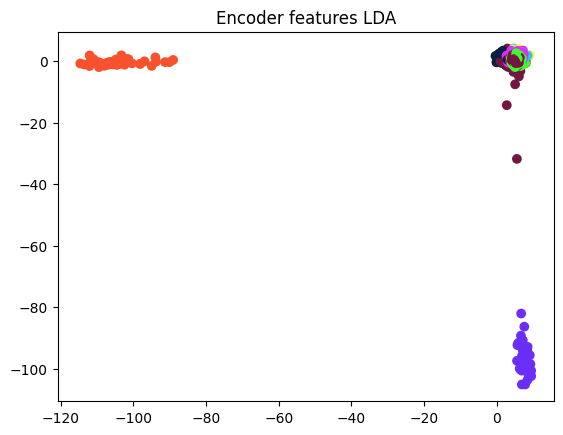

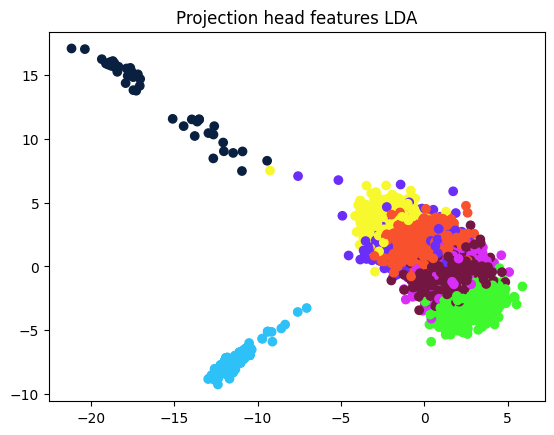

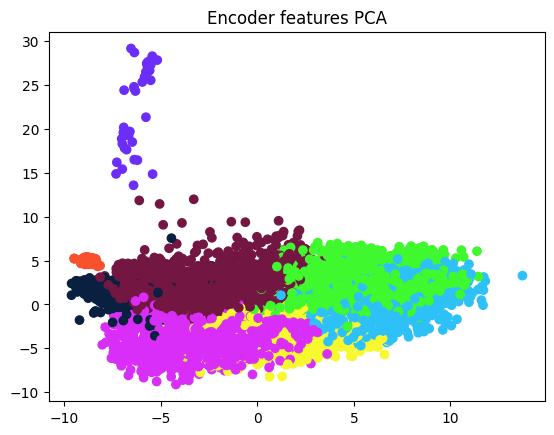

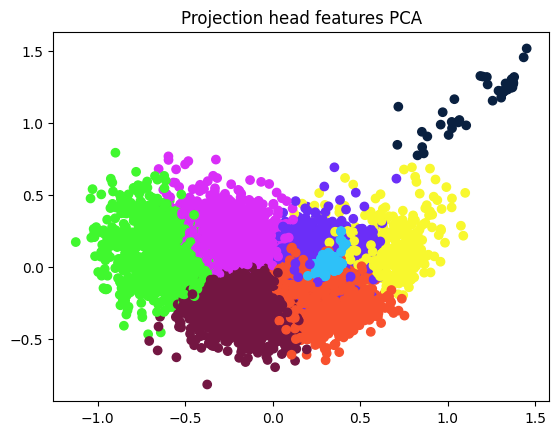

In [14]:
cluster_set, base_features, proj_features, labels_base, labels_proj, lda_base, lda_proj, pca_base, pca_proj = cluster(path, load=True, n_clusters=8, n_components=2, dataset=dataset)

### Clustering results

In [15]:
def plot_one_cluster(dataset, cluster_ind, labels):
    indexes = [i for i in range(0, len(labels)) if labels[i]==cluster_ind]

    plt.figure(figsize = (10,10))

    for i in range(0, 9):
        ax = plt.subplot(3, 3, i+1)
        ax.imshow(dataset[indexes[random.randint(0, len(indexes)-1)]]['image'].permute(1, 2, 0))

    plt.show()

#### Base encoder
Clustering based on features extracted from base encoder

c:\Users\david\Documents\PROGETTI\SIV\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


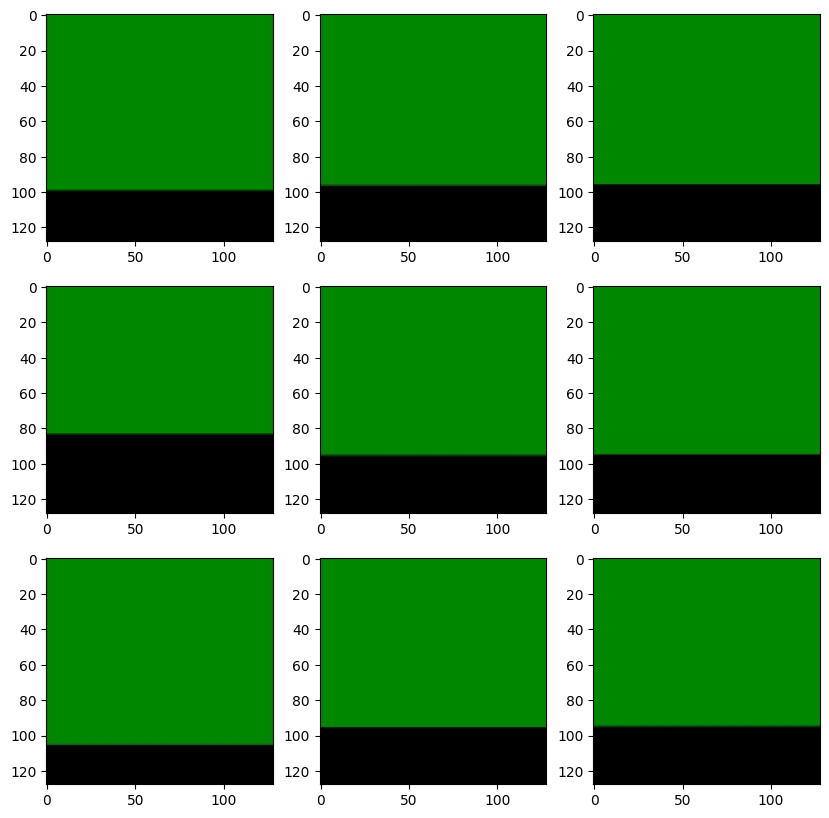

In [16]:
plot_one_cluster(cluster_set, 0, labels_base)

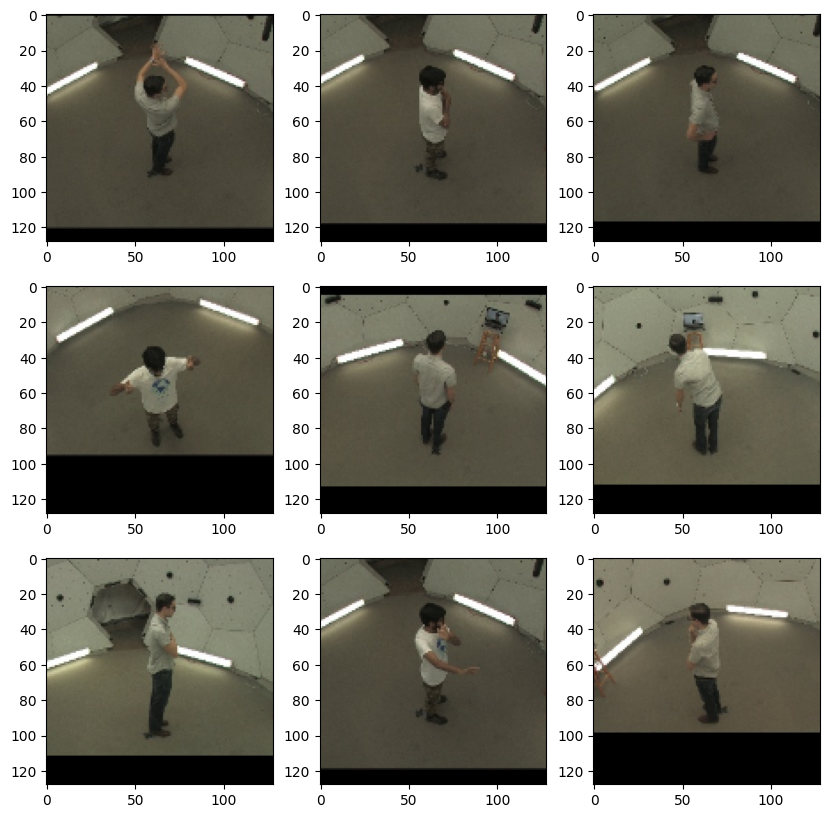

In [17]:
plot_one_cluster(cluster_set, 1, labels_base)

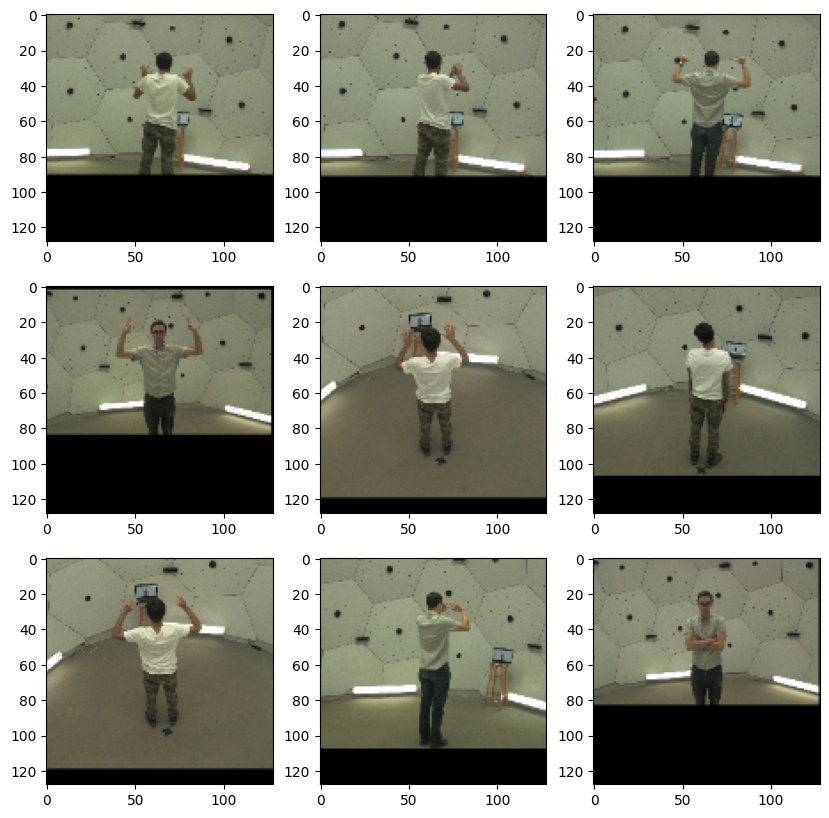

In [18]:
plot_one_cluster(cluster_set, 2, labels_base)

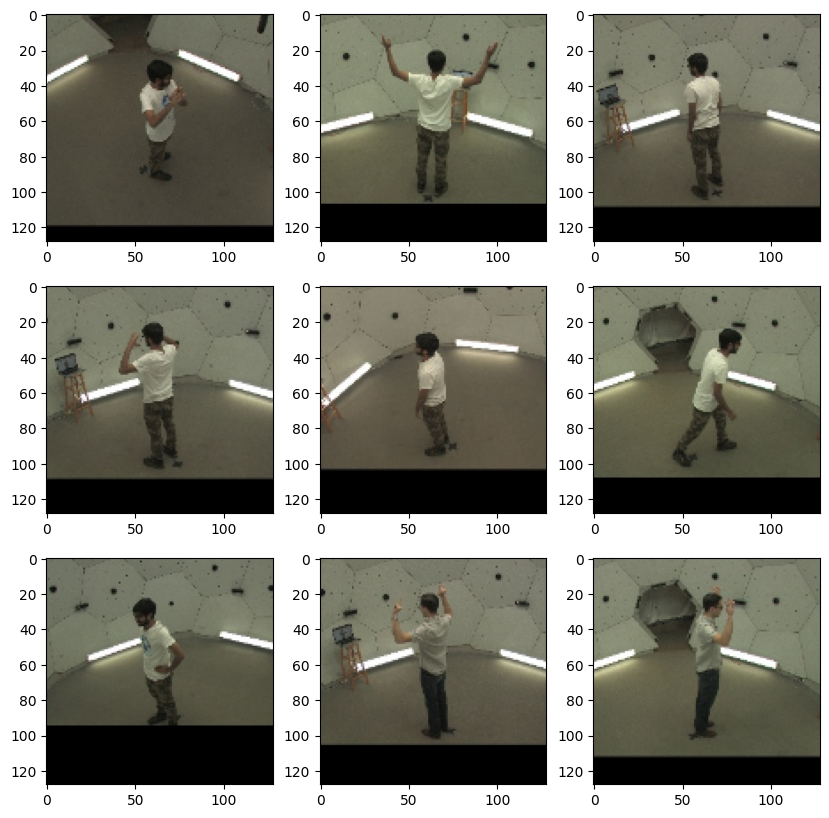

In [19]:
plot_one_cluster(cluster_set, 3, labels_base)

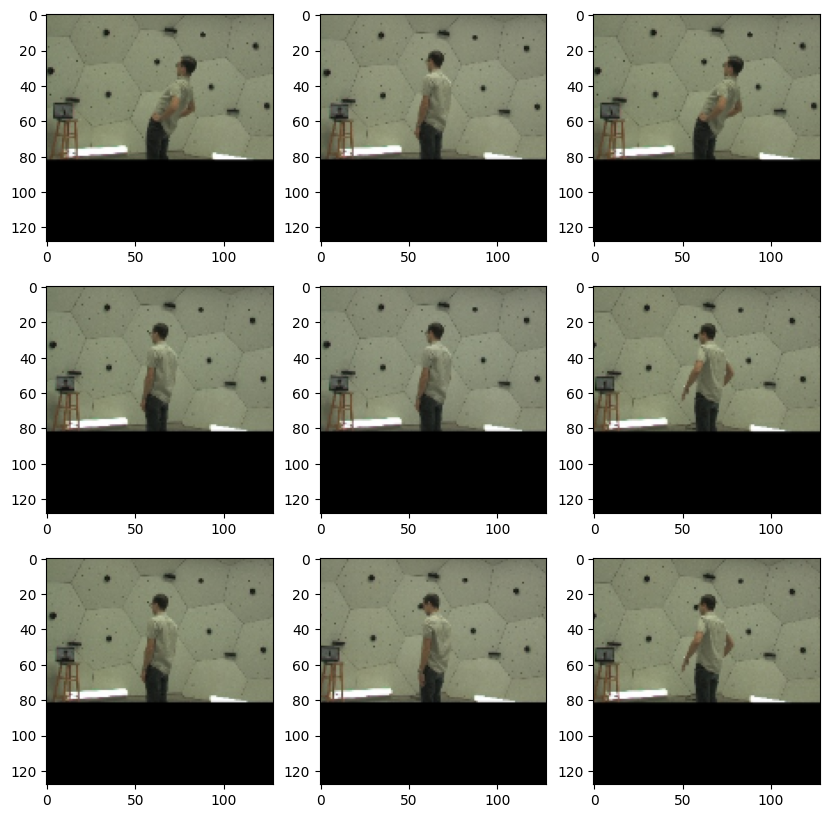

In [20]:
plot_one_cluster(cluster_set, 4, labels_base)

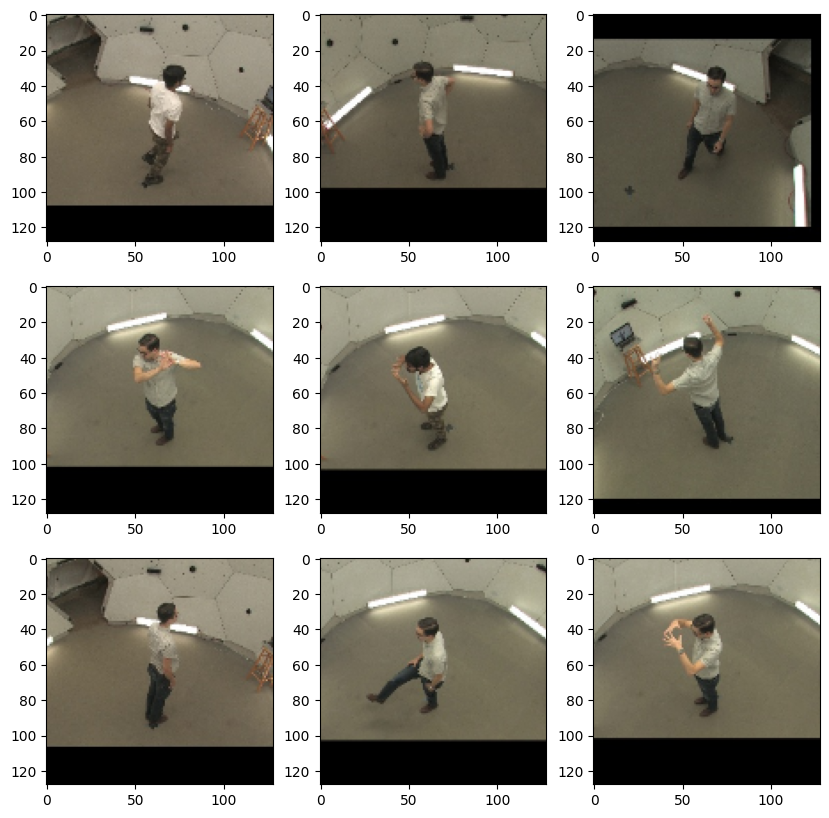

In [21]:
plot_one_cluster(cluster_set, 5, labels_base)

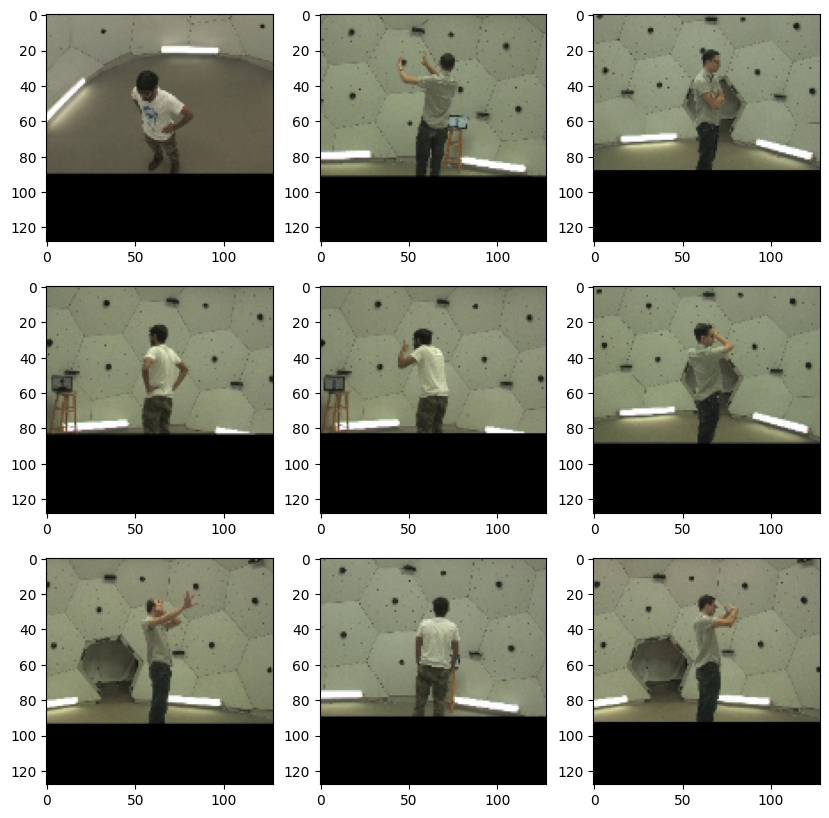

In [22]:
plot_one_cluster(cluster_set, 6, labels_base)

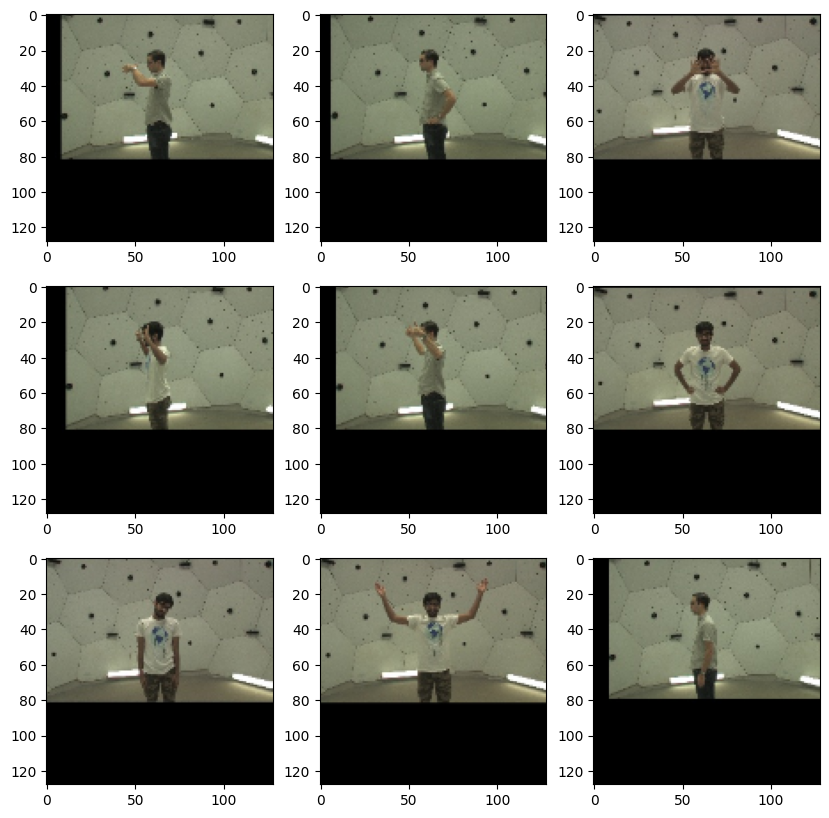

In [23]:
plot_one_cluster(cluster_set, 7, labels_base)

#### Projection head
Clustering based on features extracted from projection head

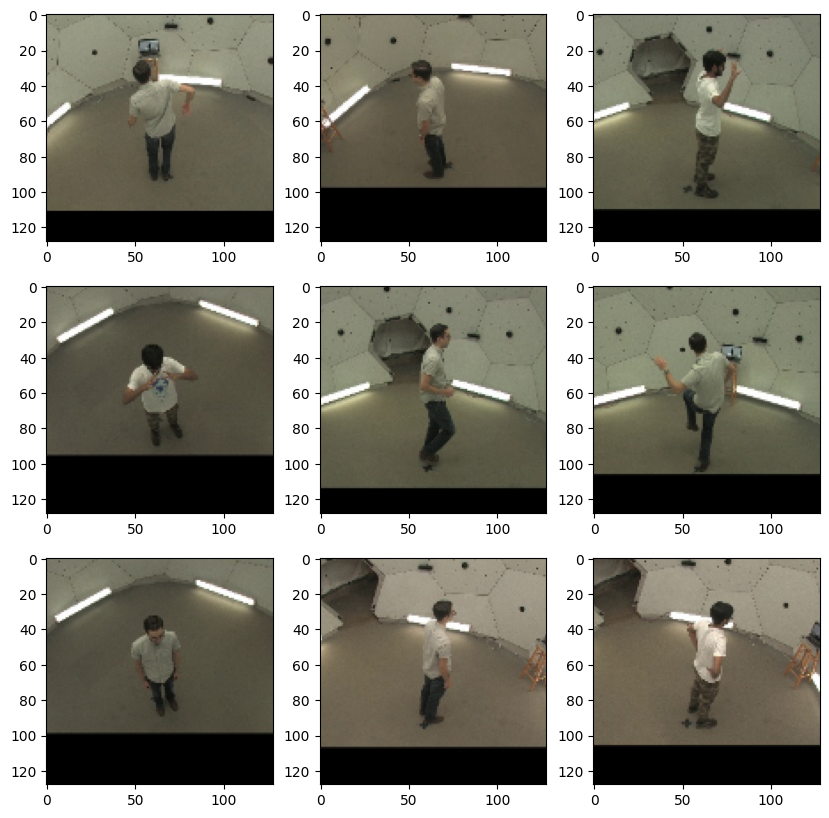

In [24]:
plot_one_cluster(cluster_set, 0, labels_proj)

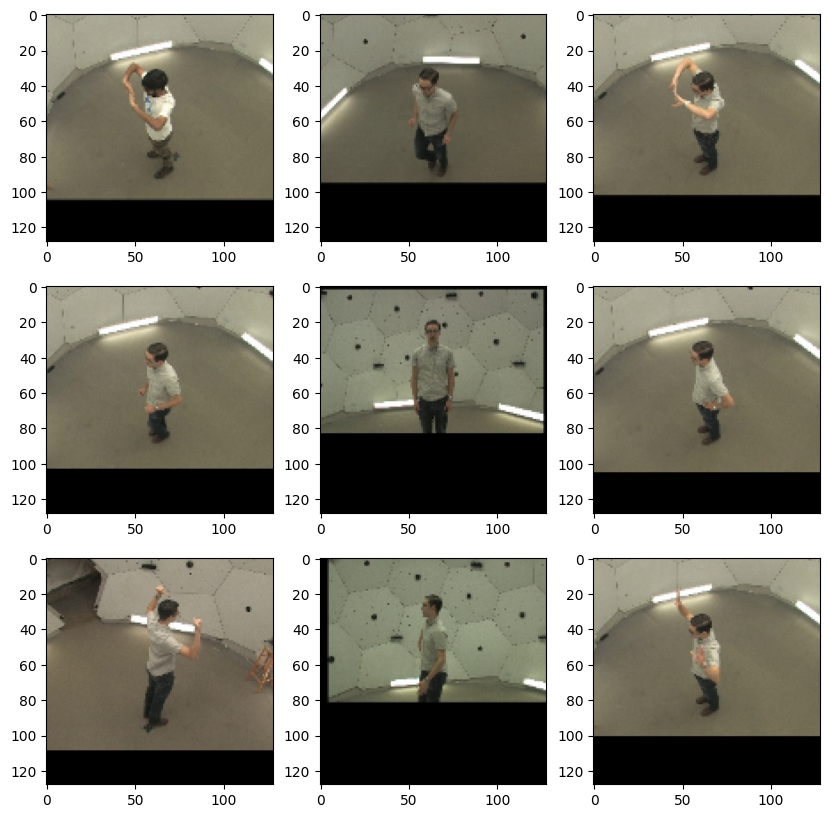

In [25]:
plot_one_cluster(cluster_set, 1, labels_proj)

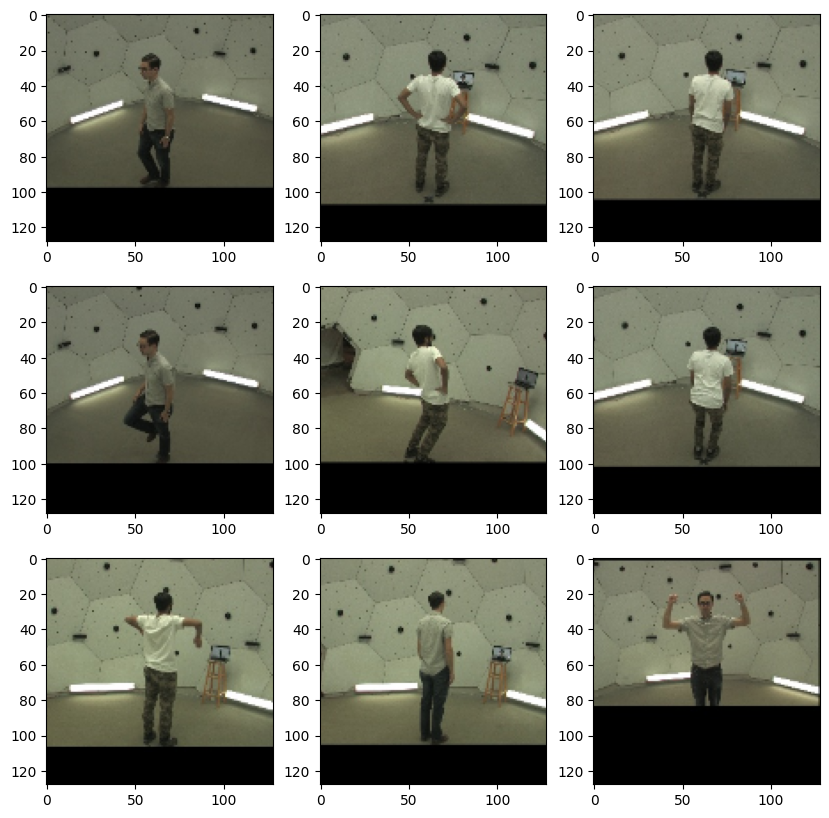

In [26]:
plot_one_cluster(cluster_set, 2, labels_proj)

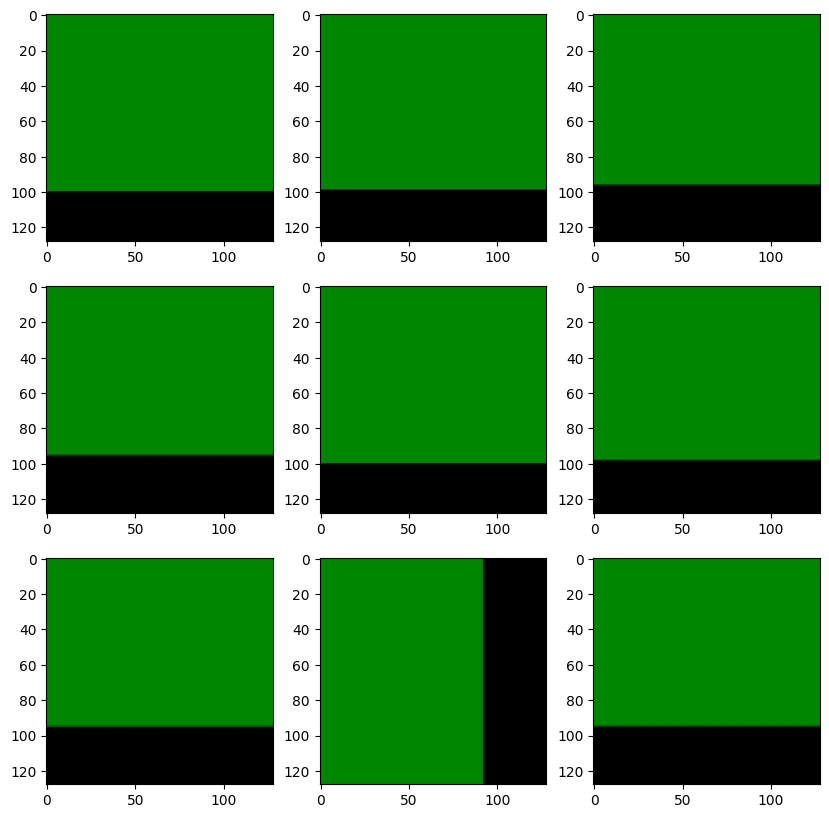

In [27]:
plot_one_cluster(cluster_set, 3, labels_proj)

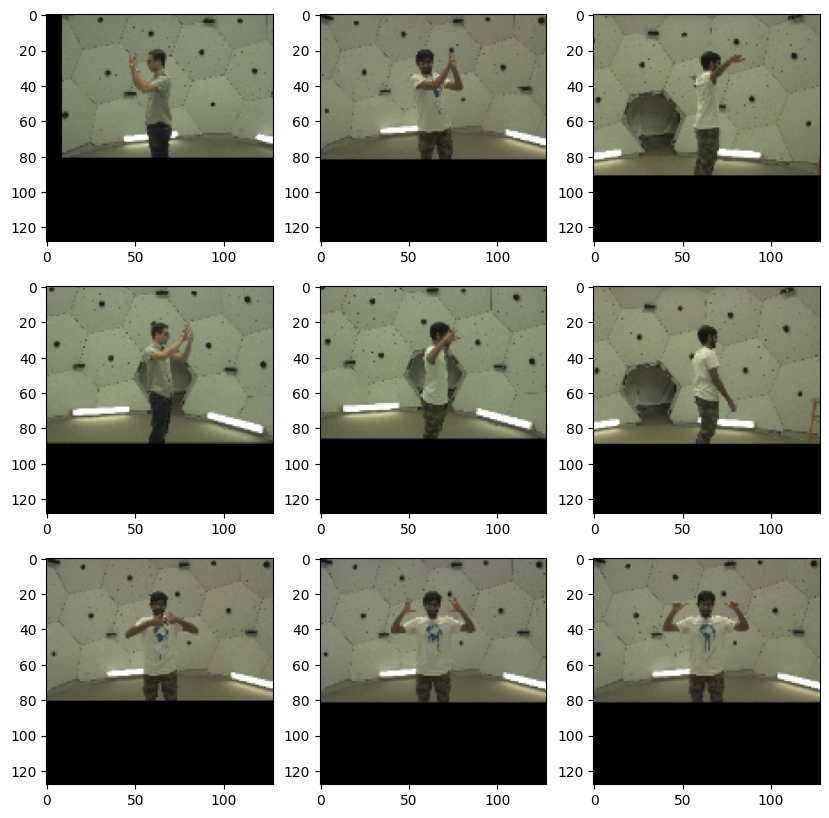

In [28]:
plot_one_cluster(cluster_set, 4, labels_proj)

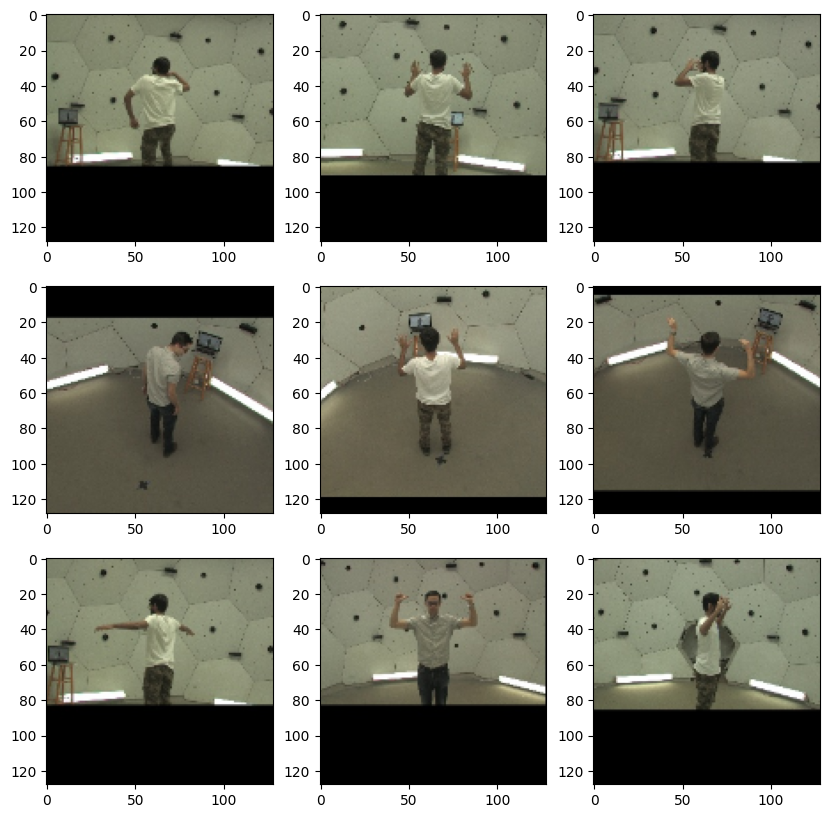

In [29]:
plot_one_cluster(cluster_set, 5, labels_proj)

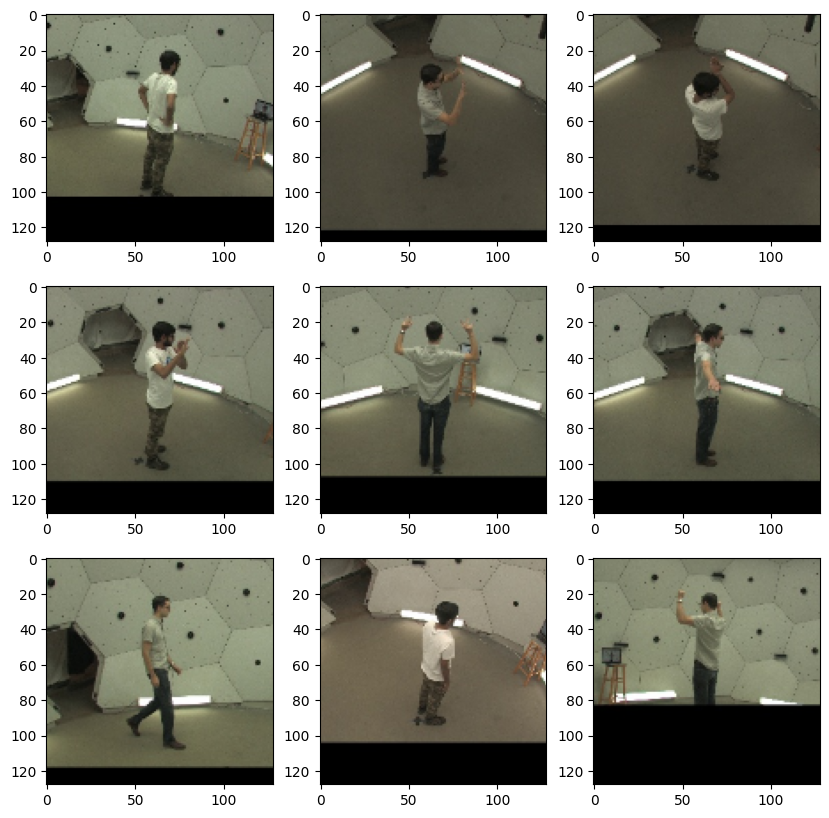

In [30]:
plot_one_cluster(cluster_set, 6, labels_proj)

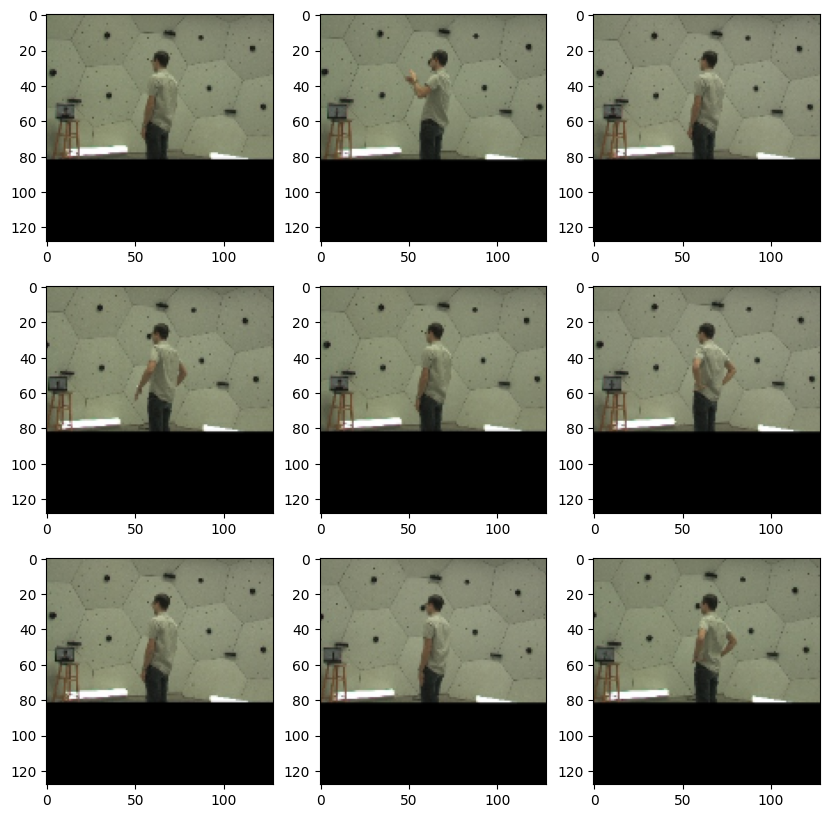

In [31]:
plot_one_cluster(cluster_set, 7, labels_proj)